# AO Data Slam: Explore Data and Fit Baseline Model

Peter Leimbigler

2023-02-18

# Imports and Setup

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.options.display.max_columns = 100
plt.rcParams['figure.facecolor'] = 'w'

# Load and Explore Data

In [3]:
df = pd.read_csv('../data/AO_2023_Training_file.csv')
df.shape

(105420, 20)

In [4]:
df.head()

,CAX_ID,gender,match_id,server_id,receiver_id,server_score,receiver_score,set_number,game_number,point,court_side,serve,in_play,in_net,receiver_position_x,outcome,point_winner,server_handedness,receiver_handedness,zone
0,1,men,888534,2efb1dd19b,bbffd1708b,0,0,1,1,1,Deuce,1,True,False,14.133262,winner,2efb1dd19b,Right,Right,0
1,2,men,888534,2efb1dd19b,bbffd1708b,15,0,1,1,2,Ad,1,False,False,14.119507,fault,2efb1dd19b,Right,Right,-1
2,3,men,888534,2efb1dd19b,bbffd1708b,15,0,1,1,2,Ad,2,True,False,13.676787,forced_error,2efb1dd19b,Right,Right,1
3,4,men,888534,2efb1dd19b,bbffd1708b,30,0,1,1,3,Deuce,1,True,False,14.155067,ace,2efb1dd19b,Right,Right,5
4,5,men,888534,2efb1dd19b,bbffd1708b,40,0,1,1,4,Ad,1,True,False,14.038913,unforced_error,bbffd1708b,Right,Right,1


In [5]:
df['server_score'].value_counts()

0     26463
40    25316
15    24421
30    21944
AD     4416
2       541
1       536
3       474
5       392
4       384
6       308
7       105
8        72
9        24
10       10
11        7
12        3
13        2
14        2
Name: server_score, dtype: int64

In [6]:
df['receiver_score'].value_counts()

0     38207
15    26284
40    18071
30    17081
AD     2827
1       539
2       539
3       479
4       448
5       372
6       328
7       117
8        63
9        34
10       11
11       11
12        4
13        2
14        2
16        1
Name: receiver_score, dtype: int64

# Prepare Data

**TODO:**
- featurize non-numeric columns
- convert target column to categorical

In [9]:
df.head()

,CAX_ID,gender,match_id,server_id,receiver_id,server_score,receiver_score,set_number,game_number,point,court_side,serve,in_play,in_net,receiver_position_x,outcome,point_winner,server_handedness,receiver_handedness,zone
0,1,men,888534,2efb1dd19b,bbffd1708b,0,0,1,1,1,Deuce,1,True,False,14.133262,winner,2efb1dd19b,Right,Right,0
1,2,men,888534,2efb1dd19b,bbffd1708b,15,0,1,1,2,Ad,1,False,False,14.119507,fault,2efb1dd19b,Right,Right,-1
2,3,men,888534,2efb1dd19b,bbffd1708b,15,0,1,1,2,Ad,2,True,False,13.676787,forced_error,2efb1dd19b,Right,Right,1
3,4,men,888534,2efb1dd19b,bbffd1708b,30,0,1,1,3,Deuce,1,True,False,14.155067,ace,2efb1dd19b,Right,Right,5
4,5,men,888534,2efb1dd19b,bbffd1708b,40,0,1,1,4,Ad,1,True,False,14.038913,unforced_error,bbffd1708b,Right,Right,1


In [10]:
# Where are the NaNs?
df.isna().sum()

CAX_ID                    0
gender                    0
match_id                  0
server_id                 0
receiver_id               0
server_score              0
receiver_score            0
set_number                0
game_number               0
point                     0
court_side                0
serve                     0
in_play                   0
in_net                    0
receiver_position_x    2158
outcome                   0
point_winner              0
server_handedness         0
receiver_handedness       0
zone                      0
dtype: int64

In [11]:
df[df['receiver_position_x'].isna()]['outcome'].value_counts()

fault             2005
forced_error        53
ace                 36
unforced_error      36
winner              28
Name: outcome, dtype: int64

In [12]:
df[df['receiver_position_x'].isna()]['zone'].value_counts()

-1    2005
 0      59
 5      41
 4      23
 1      19
 3       9
 2       2
Name: zone, dtype: int64

Most but not all rows with missing `receiver_position_x` correspond to faults.

To fit models which do not tolerate missing values, let's impute `receiver_position_x`.

In [13]:
# Forward-fill receiver_position_x using that receiver's last known position
df['receiver_position_x_ff'] = df.groupby('receiver_id', sort=False)['receiver_position_x'].ffill()

In [14]:
df[df['receiver_position_x_ff'].isna()]

,CAX_ID,gender,match_id,server_id,receiver_id,server_score,receiver_score,set_number,game_number,point,court_side,serve,in_play,in_net,receiver_position_x,outcome,point_winner,server_handedness,receiver_handedness,zone,receiver_position_x_ff
10406,10407,men,98c156,897dfec974,df165f4b1a,0,0,1,1,1,Deuce,1,True,False,NaN,forced_error,897dfec974,Left,Right,5,NaN
15572,15573,men,0154bf,66c5c4d14c,4f18690e09,0,0,1,2,1,Deuce,1,False,True,NaN,fault,66c5c4d14c,Right,Right,-1,NaN
16625,16626,men,d61400,069aa394ae,cc808fbd4a,0,0,1,2,1,Deuce,1,False,False,NaN,fault,cc808fbd4a,Right,Right,-1,NaN
18994,18995,men,ae9916,0504ed5f44,ba709b8270,0,0,1,1,1,Deuce,1,False,True,NaN,fault,0504ed5f44,Right,Right,-1,NaN
35791,35792,men,d94412,f84d5fe83c,b17783bdd6,0,0,1,1,1,Deuce,1,False,True,NaN,fault,f84d5fe83c,Right,Right,-1,NaN
66471,66472,women,3af8ff,11e526f180,0724afe4a8,0,0,1,2,1,Deuce,1,False,True,NaN,fault,0724afe4a8,Right,Right,-1,NaN
68351,68352,women,dec404,f759693ecc,35af2cbcba,0,0,1,2,1,Deuce,1,False,True,NaN,fault,f759693ecc,Right,Right,-1,NaN
72243,72244,women,505978,24bc907561,ca74ab5a14,0,0,1,1,1,Deuce,1,False,True,NaN,fault,24bc907561,Right,Right,-1,NaN
72377,72378,women,1871ad,63cb0d3fef,1eff171636,0,0,1,2,1,Deuce,1,False,True,NaN,fault,63cb0d3fef,Right,Right,-1,NaN
78480,78481,women,a5cb6a,6a5ea697f5,cdf79a7517,0,0,1,2,1,Deuce,1,False,True,NaN,fault,6a5ea697f5,Right,Right,-1,NaN


All we have left are 10 missing receiver positions, all on the very first set and point of their match. Let's just backward-fill these for now.

In [15]:
df['receiver_position_x_ff_bf'] = df.groupby('receiver_id', sort=False)['receiver_position_x_ff'].bfill()

In [16]:
df.filter(like='receiver_position').isna().sum()

receiver_position_x          2158
receiver_position_x_ff         10
receiver_position_x_ff_bf       0
dtype: int64

## Augment DataFrame with numeric features

In [17]:
# One-hot encode gender, court_side, server_handedness, receiver_handedness
featurized = pd.get_dummies(df[['gender', 'court_side', 'server_handedness', 'receiver_handedness']], drop_first=True)

df = pd.concat([df, featurized], axis=1)

### Featurize the "AD" value in score columns

Like I said, I don't know anything about tennis. Based on https://en.wikipedia.org/wiki/Tennis_scoring_system#Description, my understanding is that I can safely replace "AD" with some number higher than 40:

    The side which wins the next point after deuce [40-40] is said to have the **advantage.** If they lose the next point, the score is again deuce, since the score is tied. If the side with the advantage wins the next point, that side has won the game, since they have a lead of two points. 
    
So `score='AD'` represents a value greater than 40, since if the player with `score='AD'` wins the point, they win the game. Disclaimer: this may well be a flawed interpretation of what turns out to be a horrifyingly nonintuitive scoring system. Why is 1 point called "15"? Maybe we can just count up by 15... No, 3 points is called "40." Just... Why?

In [18]:
df[df['server_score'] == 'AD']

,CAX_ID,gender,match_id,server_id,receiver_id,server_score,receiver_score,set_number,game_number,point,court_side,serve,in_play,in_net,receiver_position_x,outcome,point_winner,server_handedness,receiver_handedness,zone,receiver_position_x_ff,receiver_position_x_ff_bf,gender_women,court_side_Deuce,server_handedness_Right,receiver_handedness_Right
41,42,men,888534,bbffd1708b,2efb1dd19b,AD,40,1,6,8,Ad,1,True,False,14.244688,forced_error,bbffd1708b,Right,Right,1,14.244688,14.244688,0,0,1,1
51,52,men,888534,2efb1dd19b,bbffd1708b,AD,40,1,9,8,Ad,1,True,False,13.994202,winner,2efb1dd19b,Right,Right,0,13.994202,13.994202,0,0,1,1
146,147,men,888534,bbffd1708b,2efb1dd19b,AD,40,3,3,10,Ad,1,False,True,NaN,fault,2efb1dd19b,Right,Right,-1,-12.355810,-12.355810,0,0,1,1
147,148,men,888534,bbffd1708b,2efb1dd19b,AD,40,3,3,10,Ad,2,False,True,-11.870680,fault,2efb1dd19b,Right,Right,-1,-11.870680,-11.870680,0,0,1,1
150,151,men,888534,bbffd1708b,2efb1dd19b,AD,40,3,3,12,Ad,1,False,True,-14.222912,fault,2efb1dd19b,Right,Right,-1,-14.222912,-14.222912,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105316,105317,women,5b8b32,aa41073377,6d5887cf32,AD,40,2,9,8,Ad,1,True,False,-11.903879,forced_error,aa41073377,Left,Right,5,-11.903879,-11.903879,1,0,0,1
105334,105335,women,5b8b32,aa41073377,6d5887cf32,AD,40,2,11,8,Ad,1,True,False,12.039714,forced_error,aa41073377,Left,Right,1,12.039714,12.039714,1,0,0,1
105388,105389,women,5b8b32,6d5887cf32,aa41073377,AD,40,3,6,8,Ad,1,False,False,-12.782290,fault,6d5887cf32,Right,Left,-1,-12.782290,-12.782290,1,0,1,0
105389,105390,women,5b8b32,6d5887cf32,aa41073377,AD,40,3,6,8,Ad,2,True,False,-11.465891,winner,6d5887cf32,Right,Left,1,-11.465891,-11.465891,1,0,1,0


In [19]:
df['server_score'].value_counts()

0     26463
40    25316
15    24421
30    21944
AD     4416
2       541
1       536
3       474
5       392
4       384
6       308
7       105
8        72
9        24
10       10
11        7
12        3
13        2
14        2
Name: server_score, dtype: int64

- 4,416 serves were by servers with the advantage.
- 2,827 serves were against receivers who had the advantage.

### Ad-hoc decision: replace `score='AD'` with `score=60`

This feels wrong, but I can't think of an obviously nicer way to featurize advantage scoring.

In [20]:
df['server_score'] = df['server_score'].replace('AD', 60).astype(int)
df['receiver_score'] = df['receiver_score'].replace('AD', 60).astype(int)

## Unexpected score values

Why are there ever values of score other than 0, 15, 30, 40, and `AD`? Should a score of "1" actually be recorded as 15? What do we do with 7, 8, 9, etc.?

In [21]:
# Glance at rows with score of 9
df[df['server_score'] == 9]

,CAX_ID,gender,match_id,server_id,receiver_id,server_score,receiver_score,set_number,game_number,point,court_side,serve,in_play,in_net,receiver_position_x,outcome,point_winner,server_handedness,receiver_handedness,zone,receiver_position_x_ff,receiver_position_x_ff_bf,gender_women,court_side_Deuce,server_handedness_Right,receiver_handedness_Right
7774,7775,men,8f710e,1885738d82,b00244c147,9,8,5,13,18,Ad,1,True,False,-15.778709,winner,1885738d82,Right,Right,5,-15.778709,-15.778709,0,0,1,1
10160,10161,men,8171ed,889205c427,a55ff5e470,9,6,5,13,16,Ad,1,False,False,14.703927,fault,889205c427,Right,Left,-1,14.703927,14.703927,0,0,1,0
10161,10162,men,8171ed,889205c427,a55ff5e470,9,6,5,13,16,Ad,2,True,False,14.816834,unforced_error,889205c427,Right,Left,2,14.816834,14.816834,0,0,1,0
17995,17996,men,b1baa2,0f5474f26e,97c93d657b,9,6,5,13,16,Ad,1,True,False,-13.855205,winner,0f5474f26e,Right,Right,5,-13.855205,-13.855205,0,0,1,1
41531,41532,men,90eea6,dd2bb09e99,33b3b10239,9,7,5,13,17,Deuce,1,True,False,13.209106,forced_error,dd2bb09e99,Right,Right,0,13.209106,13.209106,0,1,1,1
44074,44075,men,96dc78,513db17d15,83c27a9003,9,9,3,13,19,Deuce,1,True,False,14.913710,forced_error,513db17d15,Right,Right,5,14.913710,14.913710,0,1,1,1
44075,44076,men,96dc78,83c27a9003,513db17d15,9,10,3,13,20,Ad,1,True,False,-14.596713,ace,83c27a9003,Right,Right,5,-14.596713,-14.596713,0,0,1,1
45461,45462,men,a9b2f4,2cef7d9527,f0e4b831a3,9,8,2,13,18,Ad,1,True,False,14.354327,ace,2cef7d9527,Right,Right,5,14.354327,14.354327,0,0,1,1
45946,45947,men,78b78b,a8eecbc4dc,3bca958678,9,8,1,13,18,Ad,1,True,False,-13.587954,ace,a8eecbc4dc,Right,Left,5,-13.587954,-13.587954,0,0,1,0
47280,47281,men,4010df,2b9847878b,1ef61d87a0,9,9,2,13,19,Deuce,1,True,False,-13.794247,unforced_error,2b9847878b,Right,Right,1,-13.794247,-13.794247,0,1,1,1


Hmm. Unexpected server score of 9 shows up alongside unexpected receiver scores, and always on game 13... Is this another tennis thing where game 13 is scored differently?

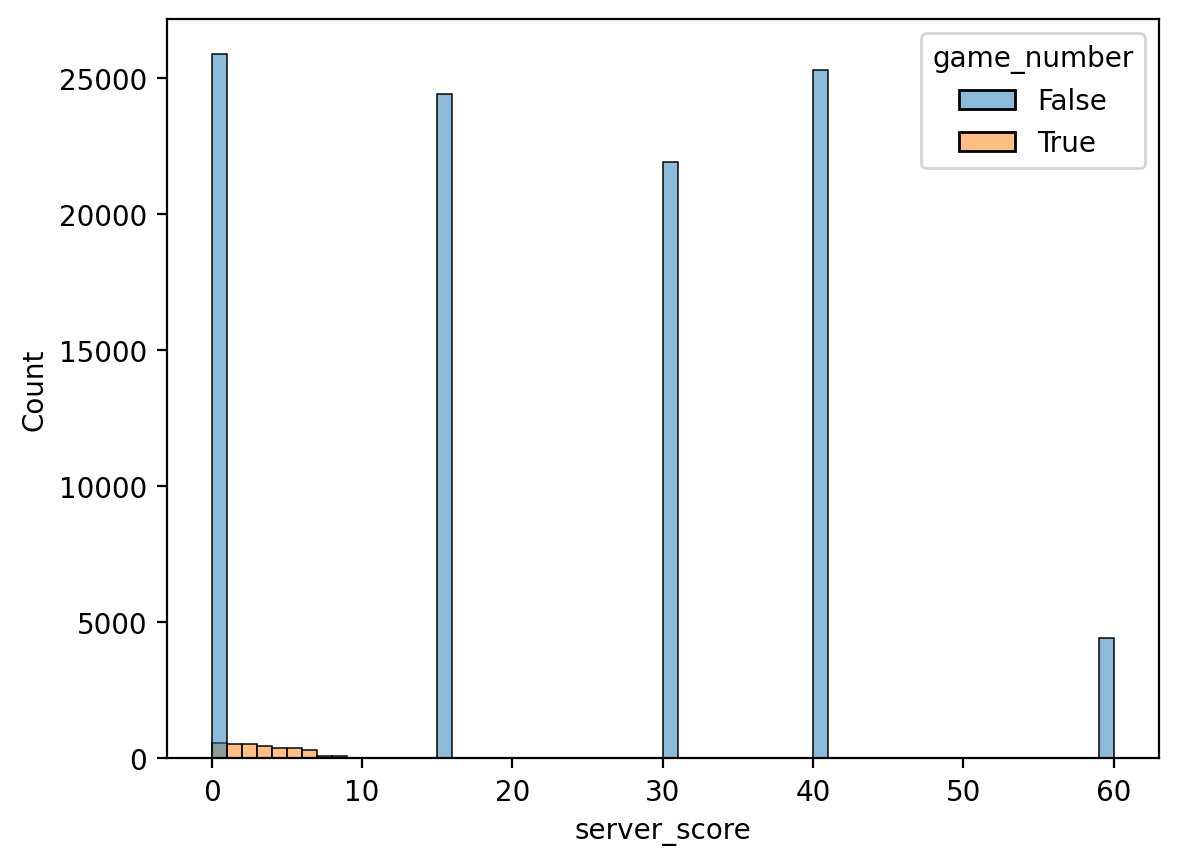

In [22]:
sns.histplot(df, x='server_score', hue=df['game_number']==13, stat='count', binwidth=1, );

Upon further reading, I see that `game=13` corresponds to tiebreak games. From https://www.usta.com/en/home/improve/tips-and-instruction/national/tennis-scoring-rules.html, emphasis mine:

    SCORING A TIEBREAK GAME
    In a tiebreak game, the next person who was due to serve will start the tiebreak game, and serve one point to the deuce side of the court. The following two points will then be served by the opponent starting on the ad side. In doubles, the player on the opposing team due to serve will serve these points.

    Players or teams switch ends of the court every six points (e.g. when the score is 4-2), and **to score this tiebreak game, you use, “zero” “one”, “two”, “three”, etc.** The first player or team to win seven points, by two, wins the tiebreak. This means the score can end up being very high (e.g. 15-13) or as low as 7-0 through 7-5. 

Again, I literally knew nothing about tennis when I started this competition. TODO: read up on why tennis reinvented the idea of counting.

In [23]:
df.dtypes

CAX_ID                         int64
gender                        object
match_id                      object
server_id                     object
receiver_id                   object
server_score                   int64
receiver_score                 int64
set_number                     int64
game_number                    int64
point                          int64
court_side                    object
serve                          int64
in_play                         bool
in_net                          bool
receiver_position_x          float64
outcome                       object
point_winner                  object
server_handedness             object
receiver_handedness           object
zone                           int64
receiver_position_x_ff       float64
receiver_position_x_ff_bf    float64
gender_women                   uint8
court_side_Deuce               uint8
server_handedness_Right        uint8
receiver_handedness_Right      uint8
dtype: object

# Model 1: Logistic Regression

Start with no attempt at player-level features. How well can we do using information about the current point only?

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

In [42]:
scaler = StandardScaler()

In [43]:
X_df = df.select_dtypes('number').drop(columns=['CAX_ID', 'receiver_position_x', 'receiver_position_x_ff', 'zone'])

In [44]:
X_df.head()

,server_score,receiver_score,set_number,game_number,point,serve,receiver_position_x_ff_bf,gender_women,court_side_Deuce,server_handedness_Right,receiver_handedness_Right
0,0,0,1,1,1,1,14.133262,0,1,1,1
1,15,0,1,1,2,1,14.119507,0,0,1,1
2,15,0,1,1,2,2,13.676787,0,0,1,1
3,30,0,1,1,3,1,14.155067,0,1,1,1
4,40,0,1,1,4,1,14.038913,0,0,1,1


In [45]:
X = X_df.values

In [46]:
y = df['zone'].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0
)

In [48]:
print(X_train.shape, X_test.shape)

(94878, 11) (10542, 11)


In [49]:
# Fit standard scaler to X_train (NOT X_test)
scaler.fit(X_train)

# Standard scale X_train and X_test using X_train parameters
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
from sklearn.metrics import get_scorer_names

In [75]:
print(get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [76]:
model_logreg = LogisticRegression(random_state=0, 
                                  multi_class='multinomial')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_logreg = cross_val_score(model_logreg, X_train, y_train, cv=cv, scoring='neg_log_loss')

In [77]:
print(f'mean ± SD log loss = {-scores_logreg.mean().round(5)} ± {scores_logreg.std().round(5)}')

mean ± SD log loss = 1.73868 ± 0.00361


In [59]:
model_logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [64]:
# Spot check 
X_train[3], y_train[3]

(array([ 1.05368181, -1.02951803, -1.05792963,  0.11130286, -0.05832268,
        -0.59815201, -1.01148571, -0.78390368, -1.04255831,  0.36118625,
         0.3589637 ]),
 5)

In [65]:
# Spot check
model_logreg.predict_proba(X[3,:].reshape(1, -1))

array([[0.14550552, 0.48142915, 0.02989421, 0.00404524, 0.00547579,
        0.02699232, 0.30665776]])

# Evaluate on holdout set

In [66]:
from sklearn.metrics import log_loss

In [67]:
y_pred = model_logreg.predict_proba(X_test)

In [68]:
log_loss(y_test, y_pred)

1.7290948214626118

In [80]:
y_pred.shape

(10542, 7)

# Model 2: sklearn HistGradientBoostingClassifier

In my quick tests, `HistGradientBoostingClassifier` trains *much* faster than `GradientBoostingClassifier`.

In [71]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [72]:
model_hgbc = HistGradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_hgbc = cross_val_score(model_hgbc, 
                              X_train, 
                              y_train, 
                              scoring='neg_log_loss', 
                              cv=cv, 
                              n_jobs=-1, 
                              error_score='raise')

In [74]:
print(f'mean ± SD log loss = {-scores_hgbc.mean().round(5)} ± {scores_hgbc.std().round(5)}')

mean ± SD log loss = 1.72485 ± 0.00343


In [90]:
model_hgbc = HistGradientBoostingClassifier()
model_hgbc.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [91]:
y_pred = model_hgbc.predict_proba(X_test)
log_loss(y_test, y_pred)

1.720198095922175